# シンプルな畳み込みニューラルネットワークのクラスを実装する

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.gradient import numerical_gradient
from common.optimizer import RMSProp

### [演習]
* 以下のSimpleConvNetクラスを完成させましょう

In [2]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        """
        input_size : 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : 畳み込みの条件, dict形式　　例、{'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}
        hidden_size : 隠れ層のノード数
        output_size : 出力層のノード数
        weight_init_std ：　重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## MNISTデータの読み込み

In [3]:
# Load the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../mnist_data/", one_hot=True) #パスは適宜変更する
train = mnist.train.images
test = mnist.test.images
train_labels = mnist.train.labels
test_labels = mnist.test.labels

/Users/ogata/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../mnist_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../mnist_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../../mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 配列形状の変換

In [4]:
train = train.reshape(-1, 1, 28, 28)
test = test.reshape(-1, 1, 28, 28)

## ミニバッチ学習
* 10epochsの計算に30分くらいかかる

In [5]:
x = train[:1000,:]
t = train_labels[:1000,:]

x = x.reshape(-1,1,28,28) # 配列形式の変換

epochs = 10
batch_size = 100

optimizer = RMSProp(lr=0.01, rho=0.9)

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                                        conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                                        hidden_size=100, output_size=10, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
    train_loss.append(snet.loss(x,  t))

    # テストデータにおけるloss
    test_loss.append(snet.loss(test, test_labels))

    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(x, t))

    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(test, test_labels))

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9


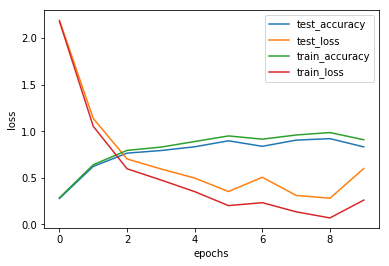

In [6]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
df_log.plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()